In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


from src.simulation_options import simulateSinglePorosity
# from Rose_data import time_points as rose_time
# from Rose_data import nds_true_conc

In [2]:
df = pd.read_csv("../lhs_results/SinglePorosityTwoFractureSimulationRuns.csv")
df = df.sort_values('MSE').reset_index(drop=True)
df.head(8)


,iteration,mean_residence_time_1,peclet_number_1,mean_residence_time_2,peclet_number_2,fractional_recovery,MSE,R2
0,7030,37.475580,1.885552,14.553631,12.690903,0.731288,0.000939,0.926946
1,6235,13.674116,25.118189,35.542481,1.554751,0.080959,0.001174,0.908691
2,8109,10.389143,49.651821,27.783494,2.633935,0.091410,0.001242,0.903417
3,6242,9.176907,95.134912,27.475221,3.377050,0.052906,0.001281,0.900407
4,6265,47.993414,1.203884,12.920855,17.093455,0.959871,0.001296,0.899194
5,2443,12.798248,7.212351,33.931319,3.273512,0.369307,0.001374,0.893181
6,5096,26.805205,2.924895,48.199927,44.478610,0.920523,0.001409,0.890439
7,2955,27.042283,2.917003,41.706166,98.070957,0.938905,0.001511,0.882465


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Parameters (kept minimal) ---
idx = 5
mrt_1 = df.loc[idx, 'mean_residence_time_1']
pec_1 = df.loc[idx, 'peclet_number_1']
mrt_2 = df.loc[idx, 'mean_residence_time_2']
pec_2 = df.loc[idx, 'peclet_number_2']
fr    = df.loc[idx, 'fractional_recovery']

time_points   = np.linspace(0.00001, 130, 500)
bckgrnd_conc  = 20.0
c_inj         = 100.0
frac_retard   = 3.5
t_values      = [0.5, 1.0, 2.5, 5.0, 7.5, 10.0, 12]  # hours
mass          = 158.9873*60*1e-6 * 10*100 * np.array(t_values)

# --- Sweep over injection durations and collect combined curves ---
curves = {}
for t in t_values:
    inj_durs  = np.cumsum(np.array([t], dtype=float))
    inj_concs = np.array([c_inj, bckgrnd_conc], dtype=float)

    first  = simulateSinglePorosity(mrt_1, pec_1, frac_retard, time_points, bckgrnd_conc, inj_concs, inj_durs)
    second = simulateSinglePorosity(mrt_2, pec_2, frac_retard, time_points, bckgrnd_conc, inj_concs, inj_durs)

    # Mix with background preserved at bckgrnd_conc
    first_adj  = (first  - bckgrnd_conc) * fr       + bckgrnd_conc
    second_adj = (second - bckgrnd_conc) * (1 - fr) + bckgrnd_conc
    combined   = first_adj + second_adj - bckgrnd_conc

    curves[f"t={t:g}"] = combined




In [4]:
# --- Save CSV: time + one column per t ---
df_out = pd.DataFrame({"time_hr": time_points, **curves})
csv_path = "../outputs/Figure_7.csv"
df_out.to_csv(csv_path, index=False)
print(f"Saved: {csv_path}")

Saved: ../outputs/Figure_7.csv


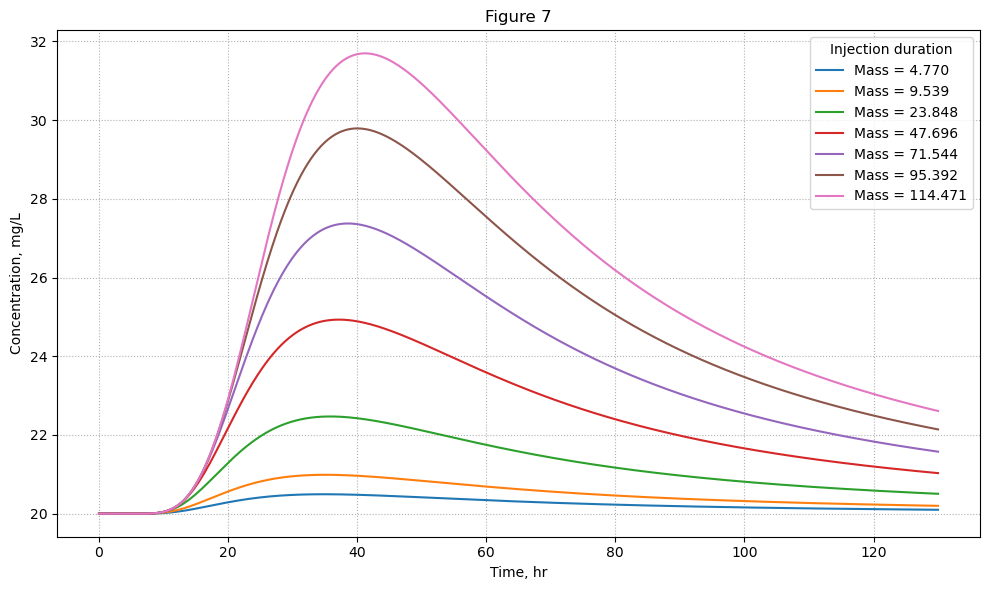

In [5]:


# --- Plot all curves on the same figure ---
plt.figure(figsize=(10, 6))
i = 0
for name, y in curves.items():
    plt.plot(time_points, y, label=f'Mass = {mass[i]:0.3f}')
    i += 1

plt.title('Figure 7')
plt.xlabel("Time, hr")
plt.ylabel("Concentration, mg/L")
plt.grid(True, which='both', linestyle=':')
plt.legend(title="Injection duration")
plt.tight_layout()
plt.show()